# Lung Cancer Survival Prediction Using Machine Learning

## Project Overview
This project aims to develop a machine learning model to predict lung cancer patient survival using clinical and diagnostic data. The objective is to analyze patient characteristics and treatment information to identify patterns associated with survival outcomes and evaluate multiple machine learning algorithms for predictive performance.

Early survival prediction can help healthcare professionals assess patient risk
and plan appropriate treatment strategies.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class imbalance handling
from imblearn.over_sampling import SMOTE

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install xgboost

###  1. Load the Dataset
The dataset is loaded into a Pandas DataFrame for analysis. Initial inspection is performed to verify that the data has been read correctly and to understand its structure.

In [3]:
# Load dataset
df = pd.read_csv("/content/dataset_med.csv")

# Display first few rows
df.head()


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


### 2. Convert Date Columns & Feature Engineering
Date columns are converted into datetime format to enable calculations. A new feature, treatment duration (in days), is created by computing the difference between diagnosis date and treatment end date. This feature represents clinically meaningful information that may influence survival prediction.

In [4]:
# Convert date columns safely (handle invalid values)
df['diagnosis_date'] = pd.to_datetime(
    df['diagnosis_date'], errors='coerce'
)

df['end_treatment_date'] = pd.to_datetime(
    df['end_treatment_date'], errors='coerce'
)

# Create treatment duration feature
df['treatment_duration_days'] = (
    df['end_treatment_date'] - df['diagnosis_date']
).dt.days

### 3. Drop Unnecessary Columns
Columns that do not contribute to prediction, such as patient identifiers and original date fields, are removed to prevent data leakage and improve model efficiency.

In [5]:
# Drop non-clinical and leakage-prone columns
df = df.drop(columns=['id', 'diagnosis_date', 'end_treatment_date'])

### 4. Handle Missing Target Values
Rows with missing survival labels are removed because machine learning models require complete target values for supervised learning.

In [6]:
# Check missing values in target variable
df['survived'].isna().sum()

np.int64(0)

In [7]:
# Remove rows with missing target values
df = df.dropna(subset=['survived'])

In [8]:
df['survived'] = df['survived'].astype(int)

### 5. Dataset Overview
The dataset shape, column types, and summary statistics are examined to understand feature distributions, detect potential anomalies, and identify preprocessing requirements.

The target variable is **survived**, indicating whether the patient survived or not.


In [9]:
# Dataset shape
df.shape

(890000, 15)

In [10]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      890000 non-null  float64
 1   gender                   890000 non-null  object 
 2   country                  890000 non-null  object 
 3   cancer_stage             890000 non-null  object 
 4   family_history           890000 non-null  object 
 5   smoking_status           890000 non-null  object 
 6   bmi                      890000 non-null  float64
 7   cholesterol_level        890000 non-null  int64  
 8   hypertension             890000 non-null  int64  
 9   asthma                   890000 non-null  int64  
 10  cirrhosis                890000 non-null  int64  
 11  other_cancer             890000 non-null  int64  
 12  treatment_type           890000 non-null  object 
 13  survived                 890000 non-null  int64  
 14  trea

In [11]:
# Statistical summary
df.describe()

,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived,treatment_duration_days
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229,458.087170
std,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401,139.326048
min,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,183.000000
25%,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000,367.000000
50%,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000,458.000000
75%,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000,550.000000
max,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,730.000000


In [12]:
# Check survival distribution
df['survived'].value_counts()

,count
survived,
0,693996
1,196004


### 6. Survival Distribution Analysis

The distribution of survival outcomes is analyzed to identify class imbalance. Visualization helps understand whether the dataset contains significantly more instances of one class compared to the other.

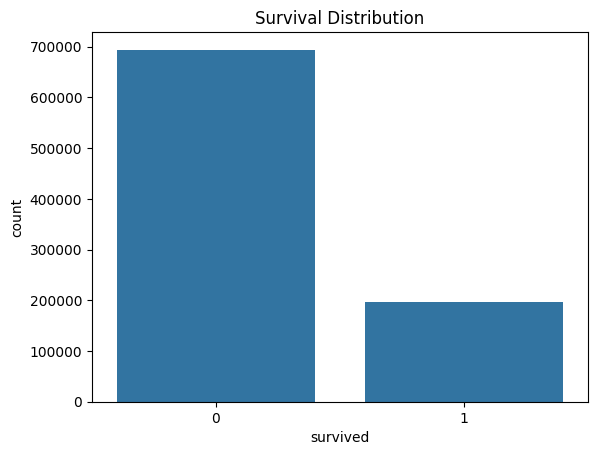

In [13]:
sns.countplot(x='survived', data=df)
plt.title("Survival Distribution")
plt.show()

### 7. Data Preprocessing


In [14]:
# Drop date columns safely
df = df.drop(columns=['diagnosis_date', 'end_treatment_date'], errors='ignore')


### Encoding Categorical Variables

Categorical features such as gender, smoking status, and treatment type are converted into numerical form using encoding techniques so that machine learning models can process them.

In [25]:
# Encode categorical columns
label_encoders = {}

for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

### Feature and Target Separation

The dataset is divided into input features (X) and the target variable (y). The target variable represents whether the patient survived or not.

In [26]:
#Feature/target split
X = df.drop('survived', axis=1)
y = df['survived']

### Train-Test Split

The dataset is split into training and testing subsets. Stratified sampling is used to preserve the original class distribution in both subsets, ensuring fair model evaluation.

In [27]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
print(X_train.dtypes)

age                        float64
gender                       int64
country                      int64
cancer_stage                 int64
family_history               int64
smoking_status               int64
bmi                        float64
cholesterol_level            int64
hypertension                 int64
asthma                       int64
cirrhosis                    int64
other_cancer                 int64
treatment_type               int64
treatment_duration_days      int64
dtype: object


In [29]:
# Keep only numeric columns
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

### SMOTE for Class Imbalance

Synthetic Minority Oversampling Technique (SMOTE) is applied to the training data to address class imbalance by generating synthetic samples for the minority class. This helps the model learn patterns from underrepresented cases more effectively.

In [30]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

### Feature Scaling

Numerical features are standardized to ensure they have similar ranges. This step improves the performance of models that are sensitive to feature scale, such as Logistic Regression.

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 8. Model Training
Multiple machine learning models are trained and compared to identify
the best-performing model for lung cancer survival prediction.

### Logistic Regression model
A Logistic Regression model is trained as a baseline classifier. This model provides a simple and interpretable reference for comparing performance with more advanced algorithms.

In [32]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

### Random Forest Model

A Random Forest classifier is implemented to capture nonlinear relationships between features and improve predictive performance through ensemble learning.

In [33]:
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

### XGBoost Model
An XGBoost classifier is trained to enhance predictive accuracy using gradient boosting. This advanced ensemble method sequentially improves model performance by correcting previous errors.

In [34]:
# Calculate imbalance ratio
neg, pos = np.bincount(y_train)
scale_weight = neg / pos

print("Scale Pos Weight:", scale_weight)

Scale Pos Weight: 1.0


In [35]:
scale_pos_weight = scale_weight

In [36]:
# XGBoost Model

xgb = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=3,   # handles imbalance
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# Train model
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]


### 9. Model evaluation
Model performance is evaluated using metrics such as accuracy, recall, ROC-AUC score, and confusion matrix. These metrics provide insights into how well the models predict survival outcomes, particularly for the minority class.


In [37]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred))

In [38]:
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")

--- Logistic Regression ---
Accuracy: 0.5862752808988764
Recall: 0.34955740924976403
ROC-AUC: 0.5003490071125758
              precision    recall  f1-score   support

           0       0.78      0.65      0.71    138799
           1       0.22      0.35      0.27     39201

    accuracy                           0.59    178000
   macro avg       0.50      0.50      0.49    178000
weighted avg       0.66      0.59      0.61    178000

--- Random Forest ---
Accuracy: 0.6425898876404494
Recall: 0.24484069283946838
ROC-AUC: 0.500141175810708
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    138799
           1       0.22      0.24      0.23     39201

    accuracy                           0.64    178000
   macro avg       0.50      0.50      0.50    178000
weighted avg       0.66      0.64      0.65    178000

--- XGBoost ---
Accuracy: 0.39481460674157304
Recall: 0.6888854876151118
ROC-AUC: 0.5009034066638239
              precision   

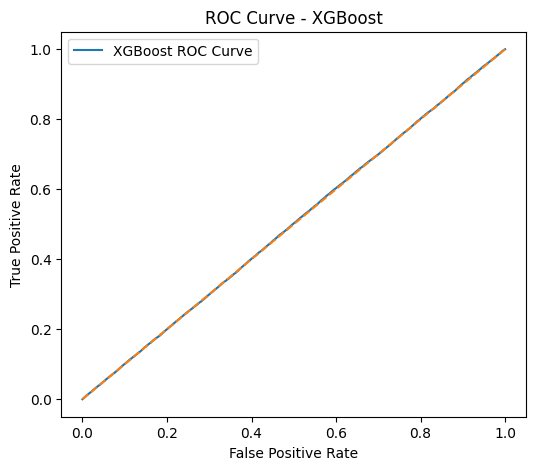

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="XGBoost ROC Curve")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - XGBoost")
plt.show()

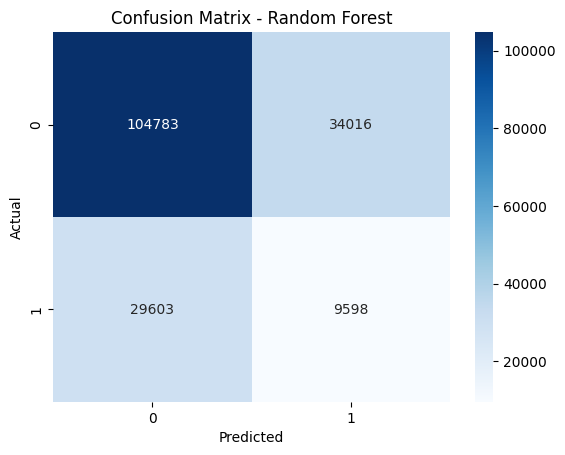

In [40]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### 10. Feature Importance
Feature importance analysis is performed to identify key factors influencing lung cancer survival predictions.

In [41]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

,0
asthma,0.139349
gender,0.134187
family_history,0.126726
cirrhosis,0.113740
smoking_status,0.111232
treatment_type,0.106337
cancer_stage,0.085303
other_cancer,0.051210
hypertension,0.044293
country,0.021129


## Conclusion
This project developed a machine learning pipeline for lung cancer survival prediction using large-scale patient diagnosis data. Feature engineering techniques, including treatment duration calculation, improved the clinical relevance of the dataset. Class imbalance challenges were addressed using SMOTE resampling, which enhanced the model’s ability to detect minority survival cases. Among the evaluated models, XGBoost demonstrated the best recall performance, making it the most suitable approach for healthcare prediction tasks where identifying positive cases is critical. The results highlight both the potential and limitations of machine learning in clinical outcome prediction.

## Future Scope
Integration of genomic and imaging data for improved prediction accuracy.

Hyperparameter tuning and advanced ensemble models.

Explainable AI techniques for clinical interpretability.

Deployment as a real-time healthcare decision support tool.